In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.interpolate import splrep, splev
import datetime as dt
import matplotlib.pyplot as plt
from fbprophet import Prophet
from scipy.interpolate import InterpolatedUnivariateSpline
%matplotlib inline
plt.rcParams.update({'font.size': 18})

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [3]:
# import multiprocessing
# def process_sat(sat_id):
#   # running prophet for single satellite
#     print(sat_id)
# pool = multiprocessing.Pool()
# print(pool.map(process_sat, range(300)))

In [4]:
def smape(satellite_predicted_values, satellite_true_values):
    # the division, addition and subtraction are pointwise
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values)/
                (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))


def drop_close(t, x, eps=10**9):
    '''
    t = time array, x = data array, eps is in nanoseconds
    Returns entries in t,x with corresponding consecutive times > eps
    
    '''
    t = np.array(t) #if not already np array, convert
    x = np.array(x) #if t or x are pandas Series, will have dimension mismatch
    far = np.concatenate([(t[1:] - t[:-1]) > eps, [True]])
    return t[far], x[far]


def resample(t, x, step=10 * 10**9, t_new=None, return_t=False):
    '''
    t: time array (or series); 
    x: data array (or series); 
    t_new: new time scale from start to end of t with step size step;
    step: = 10 seconds by default; 
    return_t: by default, do not return resampled times
    
    resample time series or array by 10 (default) sec intervals and 
    return new time series (if t_new=True) and spline approximation series for data
    
    
    '''
    t, x = drop_close(t, x)
    if t_new is None:
        t_new = np.arange(t[0], t[-1], step)
    try:
        spl = splrep(t, x)
        x_new = splev(t_new, spl)
    except:
        raise ValueError(f'interpolation error, x length = {len(x)}, \
        t_new length = {len(t_new)}')

    return (t_new, x_new) if return_t else x_new


def get_peaks(array):
    '''
    returns index of "sharp" peaks, excluding first and last values of array
    
    index of "smooth peaks", e.g. 1 2 3 9 9 3 2 1, is not returned
    '''
    return np.where((array[1:-1] > array[2:]) & (array[1:-1] > array[:-2]))[0] + 1


def get_satellite_data(data, sat_id):
    '''
    returns all data for particular satellite by id
    '''
    return data[data['sat_id'] == sat_id]


def remove_time_jumps(satellite_data, features_list=('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                      suffix='_jumps_removed',time_threshold = 0.00003):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    '''
    satellite_data['t'] = ((pd.to_datetime(satellite_data['epoch']) - pd.to_datetime(satellite_data['epoch'])[0]) /
                           np.timedelta64(1, 'D')).astype(float)
    satellite_data['dt'] = satellite_data['t'].diff()
    # the most frequent time interval
    t_standard = satellite_data['dt'].value_counts().index[0]

    # time steps used for simulations
    satellite_data['t_sim'] = satellite_data.index.values * t_standard

    n = satellite_data.shape[0]
    corrected_features = []
    for feature_name in features_list:
        corrected_feature = [0] * n
        corrected_feature[0] = satellite_data[feature_name][0]

        feature = satellite_data[feature_name]

        for j in range(1, n - 1):
            if satellite_data.t[j] < satellite_data.t_sim[j] - time_threshold:
                # approximate by the left side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] < satellite_data.t_sim[j - step] - time_threshold:
                    step += 1
                #             print(step)
                corrected_feature[j] = feature[j - step] - (satellite_data.t_sim[j - step] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j - step] - satellite_data.t_sim[j - step - 1]) * (
                                              feature[j - step] - feature[j - step - 1])
            elif satellite_data.t[j] > satellite_data.t_sim[j] + time_threshold:
                # approximate by the right side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] > satellite_data.t_sim[j + step] + time_threshold:
                    step += 1
    
                corrected_feature[j] = feature[j + step + 1] - (satellite_data.t_sim[j + step + 1] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j + step + 1] - satellite_data.t_sim[j + step]) * (
                                              feature[j + step + 1] - feature[j + step])
            else:
                corrected_feature[j] = feature[j]
    
        corrected_feature[n - 1] = feature[n - 1] + corrected_feature[n - 2] - feature[n - 2]
        corrected_features.append(corrected_feature)
    return pd.DataFrame(corrected_features, index=[f + suffix for f in features_list]).T

In [5]:
def insert_previous_and_shift(df,col_name,ind):
    '''
    input a data frame (df), column name (col_name), and index (ind)
    insert previous value of df[col_name] at index and shift the rest 
    of df[col_name] from ind by +1;
    This is used for remove_time_jumps_fast
    '''
    shifted_series = df[col_name].shift(1)
    df[col_name].iloc[ind] = df[col_name].iloc[ind-1]
    df[col_name].iloc[ind+1:] = shifted_series.iloc[ind+1:]
    return df

In [6]:
def remove_time_jumps_fast(data, features_list=
                           ('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                           threshold = 0.000001):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    s_data = satellite data
    the features are replaced by the correction
    note that threshold here is not the same as in remove_time_jumps
    '''
    data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                               np.timedelta64(1, 'D')).astype(float)
    data['dt'] = data['t'].diff(1)

    index_for_correction = data[data['dt'] < threshold].index 
    #print(index_for_correction)
    if list(index_for_correction): #if non empty
        for feature in features_list:
            for i in index_for_correction:
                data = insert_previous_and_shift(data,feature,i)
    return data

## Transforming all the data

In [7]:
import utils
from LinearAlignment import LinearAlignment

In [8]:
features_list=['x', 'y', 'z', 'Vx', 'Vy', 'Vz']

In [9]:
data = pd.read_csv('data/train.csv', index_col = 'id')
data['time'] = data['epoch']
data['epoch'] = pd.to_datetime(data['epoch']).values.astype(float)
data.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,time
id,,,,,,,,,,,,,,,
0,1.388534e+18,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,2014-01-01T00:00:00.000
1,1.388537e+18,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,2014-01-01T00:46:43.000
2,1.388540e+18,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,2014-01-01T01:33:26.001
3,1.388543e+18,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,2014-01-01T02:20:09.001
4,1.388546e+18,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,2014-01-01T03:06:52.002


In [10]:
test_data = pd.read_csv('data/test.csv', index_col = 'id')
test_data['time'] = test_data['epoch']
test_data['epoch'] = pd.to_datetime(test_data['epoch']).values.astype(float)

In [15]:
satellites_list = test_data['sat_id'].unique()
res = pd.DataFrame([])
for sat_id in tqdm(satellites_list[:200]):
    
      
    sat_data = get_satellite_data(data,sat_id)
    sat_data.loc[:,'t'] = ((pd.to_datetime(sat_data['epoch']) - pd.to_datetime(sat_data['epoch']).iloc[0]) / np.timedelta64(1, 'D')).astype(float).values
    
    test_sat_data = get_satellite_data(test_data,sat_id)
    test_sat_data.loc[:,'t'] = ((pd.to_datetime(test_sat_data['epoch']) - pd.to_datetime(test_sat_data['epoch']).iloc[0]) / np.timedelta64(1, 'D')).astype(float).values
    n_test = test_sat_data.shape[0]

    pred = pd.DataFrame(index = test_sat_data.index)
    pred['epoch'] = test_sat_data['epoch'].values
    pred['t'] = test_sat_data['t'].values
    pred['sat_id'] = sat_id

    
    try:

        for feature_name in features_list:

            q = InterpolatedUnivariateSpline(sat_data['t'], sat_data[feature_name]).roots()
            T = (q[2]-q[0])

            # create a DataFrame for prophet model()
            ts = pd.DataFrame([])
            ts['ds'] = pd.to_datetime(sat_data['epoch']).values
            ts['y'] = sat_data[feature_name].values

            # define the time frame for the first forecast
            future = pd.DataFrame([])
            future['ds'] = pd.to_datetime(test_sat_data['epoch']).values

            # define the model
            m = Prophet(changepoint_prior_scale = T/20,
            weekly_seasonality = False,
            yearly_seasonality = False).add_seasonality(name='grid', period = T, fourier_order=50)

            #fit the model and make the forecast
            m.fit(ts)
            forecast = m.predict(future)

            pred[feature_name] = forecast.loc[:, 'yhat'].values

            
    except Exception as e:
        print(f'phophet failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
        

    res = res.append(pred, sort=False)

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [11:53:09<00:00, 225.09s/it]


In [16]:
res.head()

,epoch,t,sat_id,x,y,z,Vx,Vy,Vz
id,,,,,,,,,
3927,1.391213e+18,0.000000,1,-21964.619230,-10955.054980,6529.553847,2.211446,-1.413870,1.080449
3928,1.391214e+18,0.014720,1,-17088.356142,-12494.142788,7828.371446,2.858395,-0.891626,0.744627
3929,1.391215e+18,0.029441,1,-11289.696596,-13546.388990,8812.061065,3.557261,-0.055093,0.154813
3930,1.391217e+18,0.044161,1,-4790.954018,-13863.772573,9301.081042,4.306541,1.298023,-0.871244
3931,1.391218e+18,0.058882,1,1805.768178,-13020.909657,8986.771188,5.061129,3.379915,-2.356186


In [17]:
res.to_csv('prophet_only_0_199.csv')

In [18]:
res2 = pd.read_csv('prophet_only_200_299.csv', index_col = 'id')

In [20]:
df = res.append(res2)

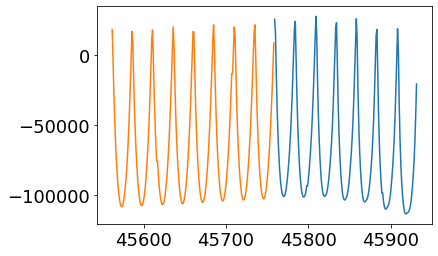

In [43]:
plt.plot(df[df.sat_id == 20].x)
plt.plot(get_satellite_data(data,20).x)

In [44]:
sub = pd.read_csv('data/submission.csv')
sub_index = sub.id.values
sub.head()

,id,x,y,z,Vx,Vy,Vz
0,3927,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3,3930,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
4,3931,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


In [46]:
q = df.loc[sub_index,['x','y','z','Vx','Vy','Vz']]

q.head()

,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,-21964.619230,-10955.054980,6529.553847,2.211446,-1.413870,1.080449
3928,-17088.356142,-12494.142788,7828.371446,2.858395,-0.891626,0.744627
3929,-11289.696596,-13546.388990,8812.061065,3.557261,-0.055093,0.154813
3930,-4790.954018,-13863.772573,9301.081042,4.306541,1.298023,-0.871244
3931,1805.768178,-13020.909657,8986.771188,5.061129,3.379915,-2.356186


In [47]:
q.to_csv('submission_9.csv')